In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

In [14]:
import nir

#### Change this to run the different model types
#model_type = 'noDelay_bias_zero'
model_type = 'noDelay_noBias_subtract'



graph = nir.read(f'braille_{model_type}.nir')



import nir_to_nengo
import importlib
importlib.reload(nir_to_nengo);

In [15]:
import torch
test_data_path = "data/ds_test.pt"
ds_test = torch.load(test_data_path)

In [16]:
from torch.utils.data import DataLoader
loader = DataLoader(ds_test, batch_size=1, shuffle=False, drop_last=False)

  0/140  target: 1   output: 1  accuracy: 1.0


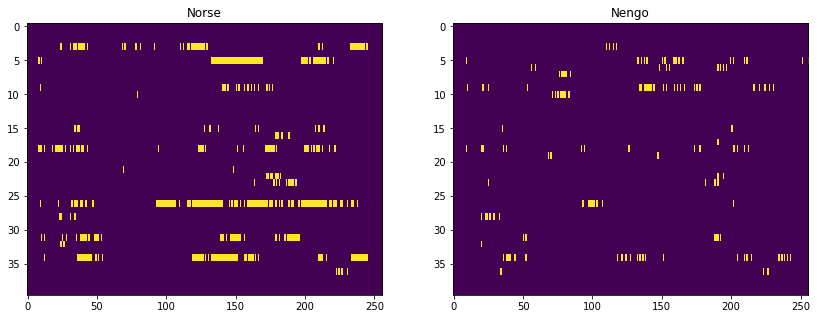

  1/140  target: 3   output: 3  accuracy: 1.0
  2/140  target: 2   output: 3  accuracy: 0.6666666666666666
  3/140  target: 2   output: 2  accuracy: 0.75
  4/140  target: 6   output: 6  accuracy: 0.8
  5/140  target: 1   output: 1  accuracy: 0.8333333333333334
  6/140  target: 1   output: 1  accuracy: 0.8571428571428571
  7/140  target: 3   output: 3  accuracy: 0.875
  8/140  target: 4   output: 2  accuracy: 0.7777777777777778
  9/140  target: 5   output: 5  accuracy: 0.8
 10/140  target: 4   output: 1  accuracy: 0.7272727272727273
 11/140  target: 0   output: 0  accuracy: 0.75
 12/140  target: 5   output: 5  accuracy: 0.7692307692307693
 13/140  target: 5   output: 5  accuracy: 0.7857142857142857
 14/140  target: 0   output: 0  accuracy: 0.8
 15/140  target: 2   output: 3  accuracy: 0.75
 16/140  target: 4   output: 4  accuracy: 0.7647058823529411
 17/140  target: 3   output: 3  accuracy: 0.7777777777777778
 18/140  target: 1   output: 1  accuracy: 0.7894736842105263
 19/140  target: 

In [17]:
import nengo
import numpy as np

dt = 1e-4

targets = np.empty(len(loader))
outputs = np.empty(len(loader))

for i, (data, labels) in enumerate(loader):
    d = data.detach().numpy()[0]
    label = labels.detach().numpy()[0]
    model = nengo.Network()
    with model:
        model2, nengo_map = nir_to_nengo.nir_to_nengo(graph, dt=dt)
        
        stim = nengo.Node(nengo.processes.PresentInput(d, presentation_time=dt))
        nengo.Connection(stim, nengo_map['input'], synapse=None, transform=1)
        p_input = nengo.Probe(nengo_map['input'])
        p_output = nengo.Probe(nengo_map['output'])
        p_lif1 = nengo.Probe(nengo_map['lif1.lif'])
        
    sim = nengo.Simulator(model, progress_bar=False, dt=dt)
    sim.run(dt*256)
    output = np.argmax(np.mean(sim.data[p_output], axis=0))
    
    targets[i] = label
    outputs[i] = output
    
    accuracy = np.mean(targets[:i+1]==outputs[:i+1])
    
    print(f'{i:3d}/{len(targets)}  target: {label}   output: {output}  accuracy: {accuracy}')
    
    if i==0:
        norse = np.load(f'norse_activity_{model_type}.npy')

        plt.figure(figsize=(14,5))
        plt.subplot(1, 2, 1)
        plt.imshow(norse.T, aspect='auto', interpolation='nearest')
        plt.title('Norse')
        plt.subplot(1, 2, 2)
        plt.title('Nengo')
        plt.imshow(sim.data[p_lif1].T, aspect='auto', interpolation='nearest')
        plt.show()
        
        np.save(f"nengo_activity_{model_type}.npy", sim.data[p_lif1].reshape((256,-1)))
        
np.save(f"nengo_accuracy_{model_type}.npy", accuracy)

In [18]:
confusion = np.zeros((7,7))
np.add.at(confusion, (targets.astype(int),outputs.astype(int)), 1)
confusion

array([[17.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 0., 20.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  3., 10.,  6.,  1.,  0.,  0.],
       [ 0.,  0.,  0., 18.,  0.,  0.,  2.],
       [ 0.,  3.,  3.,  2., 12.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 13.,  7.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 20.]])